In [1]:
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

In [2]:

backend = Aer.get_backend('statevector_simulator')

Raw Image info: (256, 256, 3)
Raw Image datatype: uint8
Image shape (numpy array): (256, 256)


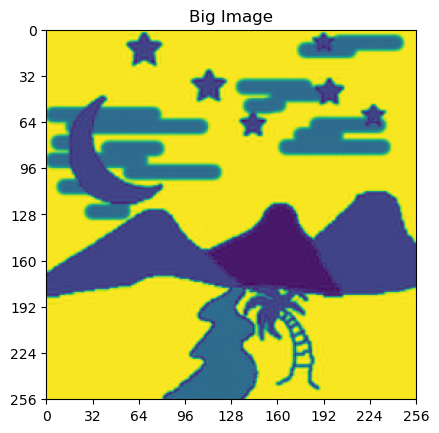

In [3]:
from PIL import Image
style.use('default')

image_size = 256       # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('./images/edge_detection_input.jpg'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
            
image = np.array(image)
print('Image shape (numpy array):', image.shape)


# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, image_crop_size))
plt.yticks(range(0, image.shape[1]+1, image_crop_size))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='viridis')
plt.show()

In [4]:
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()

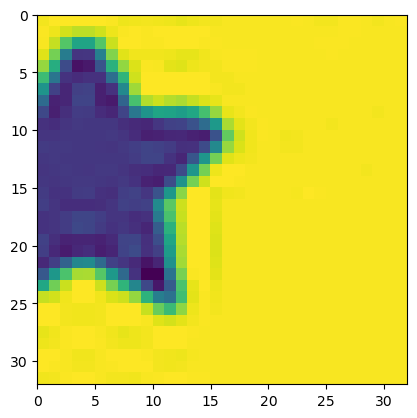

In [5]:
def split_image(image_array, split_size):
    vertical_size = image_array.shape[0]
    horizontal_size = image_array.shape[1]
    vertical_splits = vertical_size // split_size
    horizontal_splits = horizontal_size // split_size

    small_vertical_size = split_size  # Size of each smaller array
    small_horizontal_size = split_size 

    # Initialize an empty list to store the smaller arrays
    smaller_arrays = []

    for i in range(vertical_splits):
        for j in range(horizontal_splits):
            # Calculate the starting and ending indices for each smaller array
            start_row = i * small_vertical_size
            end_row = (i + 1) * small_vertical_size
            start_col = j * small_horizontal_size
            end_col = (j + 1) * small_horizontal_size

            # Extract the smaller array from the original image_array
            smaller_array = image_array[start_row:end_row, start_col:end_col]

            # Append the smaller array to the list
            smaller_arrays.append(smaller_array)

    return smaller_arrays

image_splits = split_image(image, image_crop_size)

# probamos a representar una de las imagenes para ver que esta correcta y es la imagen correspondiente al cuadrante 0-32 vertical 64-96 horizontal
plt.imshow(image_splits[2], extent=[0, image_splits[2].shape[0], image_splits[2].shape[1], 0], cmap='viridis')
plt.show()

In [6]:
from math import log2
# Initialize some global variable for number of qubits
data_qubits = int(log2(image_crop_size*image_crop_size))
anc_qubits = 1
total_qubits = data_qubits + anc_qubits

In [7]:
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_normalized = []
    for arr in img_data:
        for ele in arr:
            image_normalized.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_normalized)



In [8]:
def build_image_circuits(total_qubits, normalized_horizontal, normalized_vertical, APU, backend):
    # APU means Amplitude Permutation Unitary matrix
    # Create the circuit for horizontal scan
    qc_h = QuantumCircuit(total_qubits)
    qc_h.initialize(normalized_horizontal, range(1, total_qubits))
    qc_h.h(0)
    qc_h.unitary(APU, range(total_qubits))
    qc_h.h(0)

    # Create the circuit for vertical scan
    qc_v = QuantumCircuit(total_qubits)
    qc_v.initialize(normalized_vertical, range(1, total_qubits))
    qc_v.h(0)
    qc_v.unitary(APU, range(total_qubits))
    qc_v.h(0)

    # Combine both circuits into a single list
    circ_list = [qc_h, qc_v]

    return circ_list


In [12]:
def image_edge_finder(image, total_qubits, data_qubits, dimension, backend):
    
    # STEP 1: obtain the encoding for the horizontal and vertical dimensions of the image
    normalized_horizontal = amplitude_encode(image)
    normalized_vertical = amplitude_encode(image.T)

    # STEP 2: construimos el circuito de analisis para cada uno de los siguientes encodeos
    # Initialize the amplitude permutation unitary, APU => D2n_1
    APU = np.roll(np.identity(2**total_qubits), 1, axis=1)
    # APU means Amplitude Permutation Unitary matrix
    # Create the horizontal and vertical scan circuits
    circ_list = build_image_circuits(total_qubits, normalized_horizontal, normalized_vertical, APU, backend)

    # STEP 3: codigo para obtener el vector de estado de cada uno de los circuitos obtenidos
    # backend = Aer.get_backend('statevector_simulator')
    # extract the results and the statevectors
    results = execute(circ_list, backend=backend).result()
    statevector_horizontal = results.get_statevector(circ_list[0])
    statevector_vertical = results.get_statevector(circ_list[1])

    # STEP 4: obtención del borde de la imagen
    # Defining a lambda function for
    # thresholding to binary values
    threshold = lambda amp: (amp > 10**(-2.5) or amp < -10**(-2.5))
    # threshold = lambda amp: (amp > 10**(-4) or amp < -10**(-4))

    # Selecting odd states from the raw statevector and
    # reshaping column vector of size 64 to an 8x8 matrix
    edge_scan_h = np.abs(np.array([1 if threshold(statevector_horizontal[2*i+1].real) else 0 for i in range(2**data_qubits)])).reshape(dimension, dimension)
    edge_scan_v = np.abs(np.array([1 if threshold(statevector_vertical[2*i+1].real) else 0 for i in range(2**data_qubits)])).reshape(dimension, dimension).T


    # STEP 5: union en la imagen original
    # Combining the horizontal and vertical component of the result
    edge_scan_sim = edge_scan_h | edge_scan_v

    return edge_scan_sim



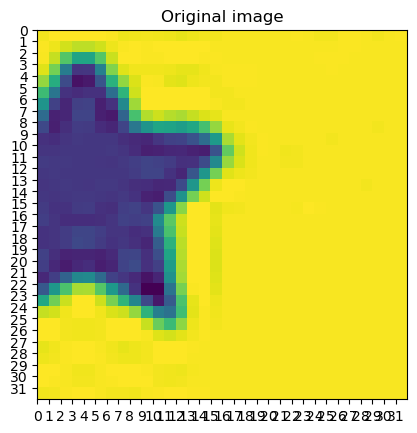

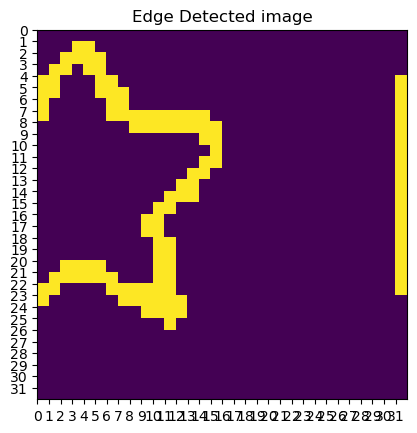

In [13]:
image_split_edges = image_edge_finder(image=image_splits[2], total_qubits=total_qubits, data_qubits=data_qubits, dimension=image_crop_size, backend=backend)

# Plotting the original and edge-detected images
plot_image(image_splits[2], 'Original image')
plot_image(image_split_edges, 'Edge Detected image')

In [14]:
def reconstruct_image(smaller_arrays, split_size):
    num_splits = len(smaller_arrays)

    # Retrieve the shape of the first smaller array to determine the dimensions
    small_vertical_size, small_horizontal_size = smaller_arrays[0].shape

    # Calculate the size of the final image
    vertical_size = small_vertical_size * split_size
    horizontal_size = small_horizontal_size * split_size

    # Initialize an empty array for the reconstructed image
    image_array = np.empty((vertical_size, horizontal_size), dtype=smaller_arrays[0].dtype)

    # Iterate over the smaller arrays and place them in the appropriate positions in the image array
    for i in range(num_splits):
        # Calculate the row and column indices for placing the smaller array
        row_idx = i // split_size
        col_idx = i % split_size

        # Calculate the starting and ending indices for placing the smaller array
        start_row = row_idx * small_vertical_size
        end_row = start_row + small_vertical_size
        start_col = col_idx * small_horizontal_size
        end_col = start_col + small_horizontal_size

        # Place the smaller array into the corresponding position in the image array
        image_array[start_row:end_row, start_col:end_col] = smaller_arrays[i]

    return image_array


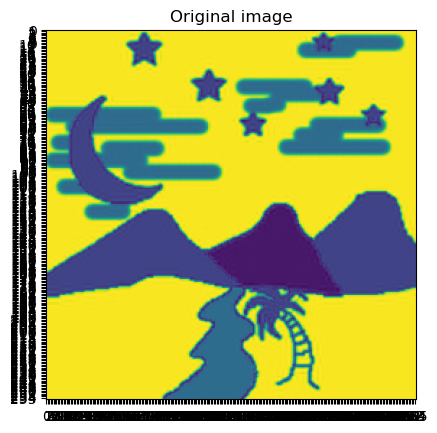

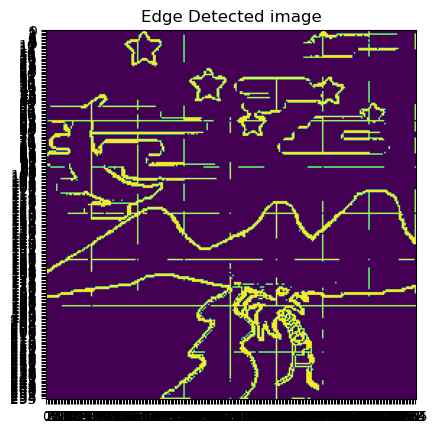

In [15]:
smaller_array_edges = []
# calculation of all the final image representations
for element in image_splits:
    smaller_array_edges.append(image_edge_finder(image=element, total_qubits=total_qubits, data_qubits=data_qubits, dimension=image_crop_size, backend=backend))

# reconstructing of the image and plotting
image_edges = reconstruct_image(smaller_arrays=smaller_array_edges, split_size=8)
# plotting both the original image and the new one
plot_image(image, 'Original image')
plot_image(image_edges, 'Edge Detected image')